In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium
from tqdm import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import torch
from torch import nn

<h1> Actor Critic on continuous actions </h1>

In [ ]:

def get_grads(model:torch.nn.Module,idx):
    g = [param.grad.detach().flatten() for param in model.parameters() if param.grad is not None]
    g = torch.cat(g).norm()
    grads[idx].append(g)

def sample(mean):
    a = mean+torch.randn(1)*0.5
    return torch.clamp(a,env.action_space.low[0],env.action_space.high[0])

class Actor:
    def __init__(self):
        self.pi = nn.Sequential(nn.Linear(2,100),
                  nn.ReLU(),
                  nn.Linear(100,2))
    def log_prob(self,state,action):
        dist =self._get_dist(state)
        return dist.log_prob(action)
    
    def sample(self):
        dist =self._get_dist(state)
        return dist.sample((1,))
    
    def _get_dist(self,state):
        mu,sigma = self.pi(state)
        dist = torch.distributions.Normal(mu,sigma+1e-5)
        
        
def get_nn_v():
    return nn.Sequential(nn.Linear(2,400),
                  nn.ReLU(),
                  nn.Linear(400,1))
def get_nn_pi():
    return nn.Sequential(nn.Linear(2,100),
                  nn.ReLU(),
                  nn.Linear(100,2))
def v(s,model):
    

In [ ]:
torch.exp(torch.distributions.Normal(0,1).log_prob(torch.tensor(0)))

Text(0.5, 1.0, 'Loss')

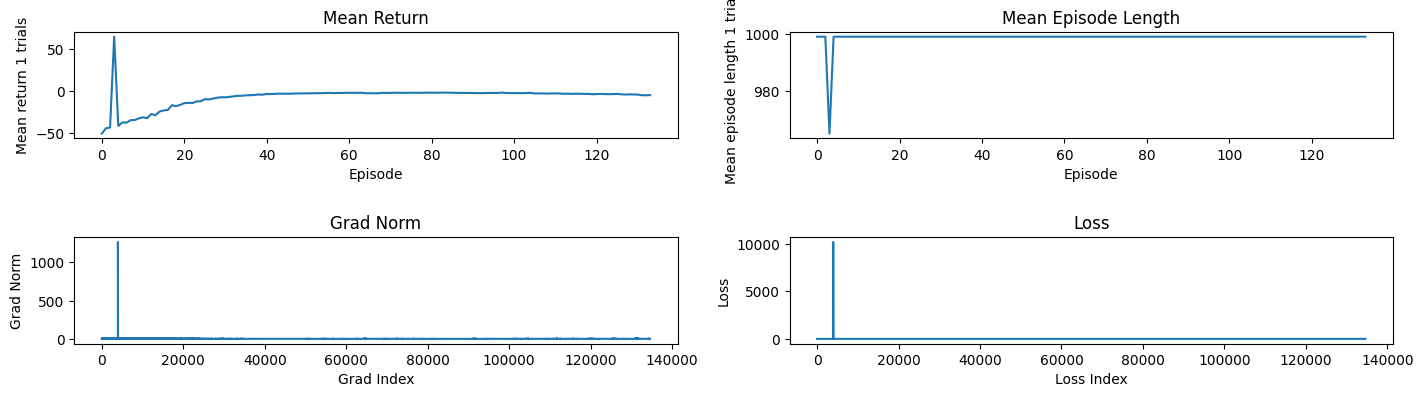

In [112]:
NUM_TRIALS = 1
NUM_EPISODES = 1000
ALPHA_V = 56e-7
ALPHA_PI = 1e-7
env = gymnasium.make("MountainCarContinuous-v0")
mse_loss = nn.MSELoss()
returns = np.zeros((NUM_TRIALS,NUM_EPISODES))
ep_lens = np.zeros((NUM_TRIALS,NUM_EPISODES))
grads = [[],[]]
losses = [[],[]]

for i in range(NUM_TRIALS):
    v = get_nn_v()
    pi_network = get_nn_pi()
    pi_op = torch.optim.SGD(pi_network.parameters(),lr=ALPHA_PI)
    v_op = torch.optim.SGD(v.parameters(),lr=ALPHA_V)
    for j in tqdm(range(NUM_EPISODES)):
        ret = 0.
        ep_len=0.
        state,*_ = env.reset()
        state = torch.from_numpy(state).detach()
        while True:
            with torch.no_grad():
                logit = pi(state)
                if np.isnan(logit):
                    raise Exception("Action is nan")
                action = sample(logit)
            next_state,reward,terminated,truncated,*_ = env.step(action)
            ret+=reward
            ep_len+=1
            #Update critic
            with torch.no_grad():
                next_state = torch.from_numpy(next_state)
                target = torch.tensor([reward]) + (v(next_state) if not terminated else 0)
            est_v = v(state)
            loss = mse_loss(target,est_v)
            loss.backward()
            losses[0].append(loss.item())
            get_grads(v,0)
            v_op.step()
            v_op.zero_grad()
            #Update actor
            with torch.no_grad():
                critic_est = torch.tensor([reward]) + (v(next_state) if not terminated else 0) - v(state)
            est_pi = pi(state)
            loss = critic_est*mse_loss(action,est_pi)
            loss.backward()
            losses[1].append(loss.item())
            get_grads(pi,1)
            pi_op.step()
            pi_op.zero_grad()
            if terminated or truncated:
                if terminated:
                    print("Achieved target in ",ep_len)
                break
            state = next_state
        returns[i,j] = ret
        ep_lens[i,j] = ep_len
        if ep_len <=1:
            raise Exception("Low ep len")
        

In [ ]:
fig:Figure
ax1:Axes
ax2:Axes
ax3:Axes
ax4:Axes
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_figwidth(20)
fig.set_figwidth(15)
fig.tight_layout(pad=5.0)
ax1.plot(np.mean(returns,axis=0))
ax1.set_ylim(top=100)
ax1.set_ylabel(f"Mean return {NUM_TRIALS} trials")
ax1.set_xlabel("Episode")
ax1.set_title("Mean Return")
ax2.plot(np.mean(ep_lens,axis=0))
ax2.set_ylabel(f"Mean episode length {NUM_TRIALS} trials")
ax2.set_xlabel("Episode")
ax2.set_title("Mean Episode Length");
idx=0
ax3.plot(grads[idx])
ax3.set_ylabel(f"Grad Norm")
ax3.set_xlabel("Grad Index")
ax3.set_title("Grad Norm");
ax3.set_ylim(0,20)
ax4.plot(losses[idx])
ax4.set_ylabel(f"Loss")
ax4.set_xlabel("Loss Index")
ax4.set_title("Loss");
ax4.set_ylim(0,2)

In [ ]:
list(v.parameters())[1]

In [ ]:
action_lst